# Εργασία 1. Επιβλεπόμενη Μάθηση - Kaggle dataset
Neural Networks - Team 22\
\
Alexandros Tsafos el18211\
Christina Kostaki el18136\
Sofia Vouzika el18843
  

Αρχικά κάνουμε upgrade στις βιβλοθήκες που θα χρειαστούμε, αν δεν έχουμε ήδη κάνει. Στο Colab θα χρεαστεί πιθανότατα να κάνουμε restart το runtime.

In [1]:
!pip install --upgrade pip
!pip install scikit-learn --upgrade 
!pip install numpy --upgrade 
!pip install --upgrade matplotlib 
!pip install --upgrade pandas
!pip install tabulate
!pip install -U imbalanced-learn
!pip install optuna

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

![Κaggle Logo](https://upload.wikimedia.org/wikipedia/commons/7/7c/Kaggle_logo.png "Kaggle")

To [Kaggle](https://www.kaggle.com) είναι το δεύτερο αποθετήριο datasets για Machine Learning που θα δούμε σε αυτή την άσκηση. Το dataset με το οποίο θα δουλέψουμε είναι το [Codon Usage](https://www.kaggle.com/datasets/meetnagadia/condon-usage-dataset). Το dataset περιλαμβάνει διάφορες πληροφορίες σχετικά με την χρήση κωδικονίων σε ένα μεγάλο εύρος οργανισμών, με σκοπό να γίνει ταξινόμηση κατά γένος ("Βασίλειο").





In [2]:
import pandas as pd
import numpy as np

def conv(val):
    try:
        return float(val)
    except:
        return np.nan

# Read CSV and replace the uknown Age values with the average Age.
dataset = pd.read_csv("codon_usage.csv", low_memory=False, converters={'UUU': conv, 'UUC':conv})
print(dataset.shape)

print(dataset.isnull().sum().sort_values(ascending=False))



(13028, 69)
UUU        2
UUC        1
Kingdom    0
UAU        0
UGU        0
          ..
GGU        0
GGC        0
GGA        0
GGG        0
UGA        0
Length: 69, dtype: int64


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13026 non-null  float64
 6   UUC          13027 non-null  float64
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

### Απαραίτητο Preprocessing

Σε αυτό το σημείο πρέπει να γίνει το ελάχιστο preprocessing, έτσι ώστε το sci-kit learn να μπορέσει να επεξεργαστεί τα δεδομένα.

Παρακάτω θα δούμε πιο αναλυτικά αυτές τις αλλαγές

Η στήλη Species name δεν μπορεί να χρησιμοποιηθεί, καθώς είναι τύπου string. Μπορούμε να την αφαιρέσουμε, αφού το SpeciesID μας είναι αρκετό για τον καθορισμό του είδους. Ο owner των δεδομένων έχει κάνει ήδη προεργασία για εμάς, έχοντας μεριμνήσει για αυτή την εξάρτηση. Σε αντίθετη περίπτωση, θα έπρεπε να κάνουμε εμείς το class mapping.

In [4]:
# Cannot process string values in MLP. 
# We have the ID as index se we can drop the whole column
dataset = dataset.drop(columns='SpeciesName')

 To dataset έχει 3 ΝaN τιμές. Αυτές πρέπει να αλλάξουν για να μπορέσουμε να συνεχίσουμε.
 Επιλέγουμε να τις κάνουμε drop, καθώς αποτελούν αμελητέο μέρος των δεδομένων.

In [5]:
# Drop the Null Values. These are 2 out of 13028 rows
dataset.dropna(inplace=True)
dataset.set_index("SpeciesID")

print("The NaN values now are: " + str(dataset.isnull().sum().sum()))
print(dataset.shape)

The NaN values now are: 0
(13026, 68)


Έχουμε ένα dataframe, από το οποίο πρέπει να εξάγουμε δεδομένα συμβατά με το sklearn

In [6]:
# Extract the values
label_names, counts = np.unique(dataset["Kingdom"], return_counts=True) 
labels = dataset["Kingdom"].values
features = dataset.iloc[:,1:].values
feature_names = dataset.columns[1:]

In [7]:
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(str(u)+':'+str(c))

arc:126
bct:2919
inv:1345
mam:572
phg:220
plm:18
pln:2523
pri:180
rod:215
vrl:2831
vrt:2077


To dataset δεν είναι ισορροπημένο. Το plm εμφανίζεται 18 φορές, ενώ το bct 2919.
Περισσότερες από 100 φορές παραπάνω.

In [8]:
# οι διαστάσεις όλων των χαρακτηριστικών
print(features.shape)


(13026, 67)


### Train and Test split

Θα κάνουμε ένα απλό train and test split 70% εκπαίδευση και 30% δείγματα.
Το διαλέγουμε σαν απλή και συνηθισμένη τιμή για την επίδοση out-of-the-box. Αργότερα, κατά την βελτιστοποίηση, θα αποφασίσουμε αν αυτό το ποσοστό θα αλλάξει.

In [9]:
from sklearn.model_selection import train_test_split

# Split our data
train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.3)

In [10]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

kaggle_accuracy = {}
kaggle_f1 = {}
kaggle_fit = {}
kaggle_pred = {}

def dummy_metrics(solver, const = None):

    name = 'dummy_' + solver
    model = DummyClassifier(strategy=solver, constant=const)
    start = time.time()
    model.fit(train, train_labels)
    fit_time  = time.time() - start
    start = time.time()
    preds = model.predict(test)
    pred_time  = time.time() - start

    kaggle_pred[name] = pred_time
    kaggle_fit[name] = fit_time
    kaggle_accuracy[name] = accuracy_score(test_labels, preds)
    kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

dummy_metrics('uniform')
dummy_metrics('most_frequent')
dummy_metrics('stratified')
dummy_metrics('constant', 'arc')
dummy_metrics('constant', 'mam')

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

def mlp_metrics(solver):

    name = 'mlp_' + solver
    model = MLPClassifier(solver=solver)
    start = time.time()
    model.fit(train, train_labels)
    fit_time  = time.time() - start
    start = time.time()
    preds = model.predict(test)
    pred_time  = time.time() - start

    kaggle_pred[name] = pred_time
    kaggle_fit[name] = fit_time
    kaggle_accuracy[name] = accuracy_score(test_labels, preds)
    kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

mlp_metrics('adam')
mlp_metrics('lbfgs')
mlp_metrics('sgd')



## Σχόλιο

Ο SVM, αργεί πάρα πολύ να κάνει fit, αν δεν μπει όριο στο max_iter. Αυτό είναι λογικό, αφού κρατά έναν ΝxN πίνακα για τις αποστάσεις όλων των σημείων. Με 13000 εγγραφές, καταλαβαίνουμε πως αυτός ο πίνακας είναι πολύ μεγάλος για να γίνει γρήγορα η επεξεργασία του. Για τώρα, θα περιορίσουμε τις επαναλήψεις του, ενώ, κατά την βελτιστοποίηση, θα μικρύνουμε αρκετά το dataset μας.

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

def svc_metrics(solver):

    name = 'svc_' + solver
    model = SVC(kernel=solver, random_state=0, C=1, max_iter=100000)
    start = time.time()
    model.fit(train, train_labels)
    fit_time  = time.time() - start
    start = time.time()
    preds = model.predict(test)
    pred_time  = time.time() - start

    kaggle_pred[name] = pred_time
    kaggle_fit[name] = fit_time
    kaggle_accuracy[name] = accuracy_score(test_labels, preds)
    kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

svc_metrics('poly')
svc_metrics('rbf')

In [13]:
from IPython.display import Markdown

merged_metrics = [(k, kaggle_fit[k], kaggle_pred[k], kaggle_accuracy[k], kaggle_f1[k]) for k in sorted(kaggle_accuracy, key=kaggle_accuracy.get, reverse=True)]

df = pd.DataFrame(merged_metrics, columns=['Classifier', 'Fit Time(s)', 'Test Time(s)','Accuracy','F1-macro'])
Markdown(df.to_markdown())

|    | Classifier          |   Fit Time(s) |   Test Time(s) |   Accuracy |   F1-macro |
|---:|:--------------------|--------------:|---------------:|-----------:|-----------:|
|  0 | svc_rbf             |    4.5865     |    3.12811     |  0.311668  | 0.100513   |
|  1 | svc_poly            |    9.50887    |    1.27472     |  0.250256  | 0.0568606  |
|  2 | mlp_lbfgs           |    0.659701   |    0.00353217  |  0.22825   | 0.0614462  |
|  3 | dummy_most_frequent |    0.00186205 |    0.000354767 |  0.223132  | 0.0331685  |
|  4 | mlp_sgd             |    0.586501   |    0.00268817  |  0.223132  | 0.0331685  |
|  5 | mlp_adam            |    0.721599   |    0.00481987  |  0.195241  | 0.0577745  |
|  6 | dummy_stratified    |    0.00181103 |    0.000962019 |  0.177584  | 0.0929277  |
|  7 | dummy_uniform       |    0.00233912 |    0.000931978 |  0.0962129 | 0.0723134  |
|  8 | dummy_constant      |    0.00178885 |    2.90871e-05 |  0.0450358 | 0.00783546 |

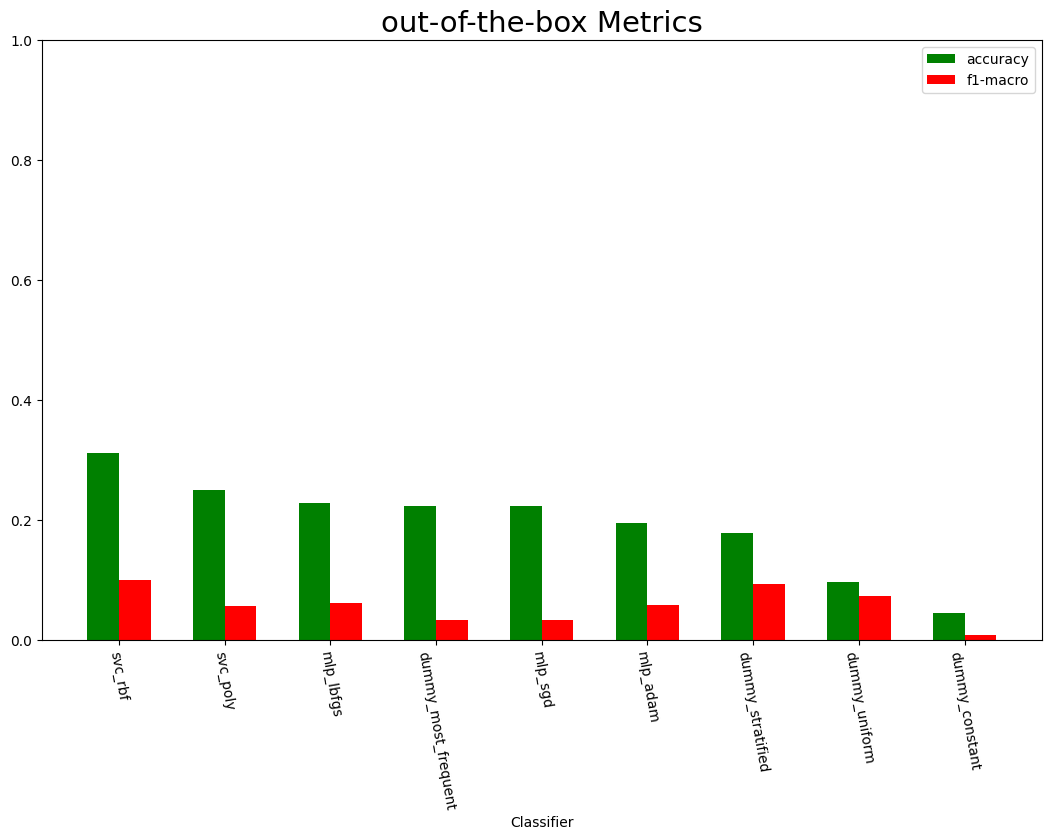

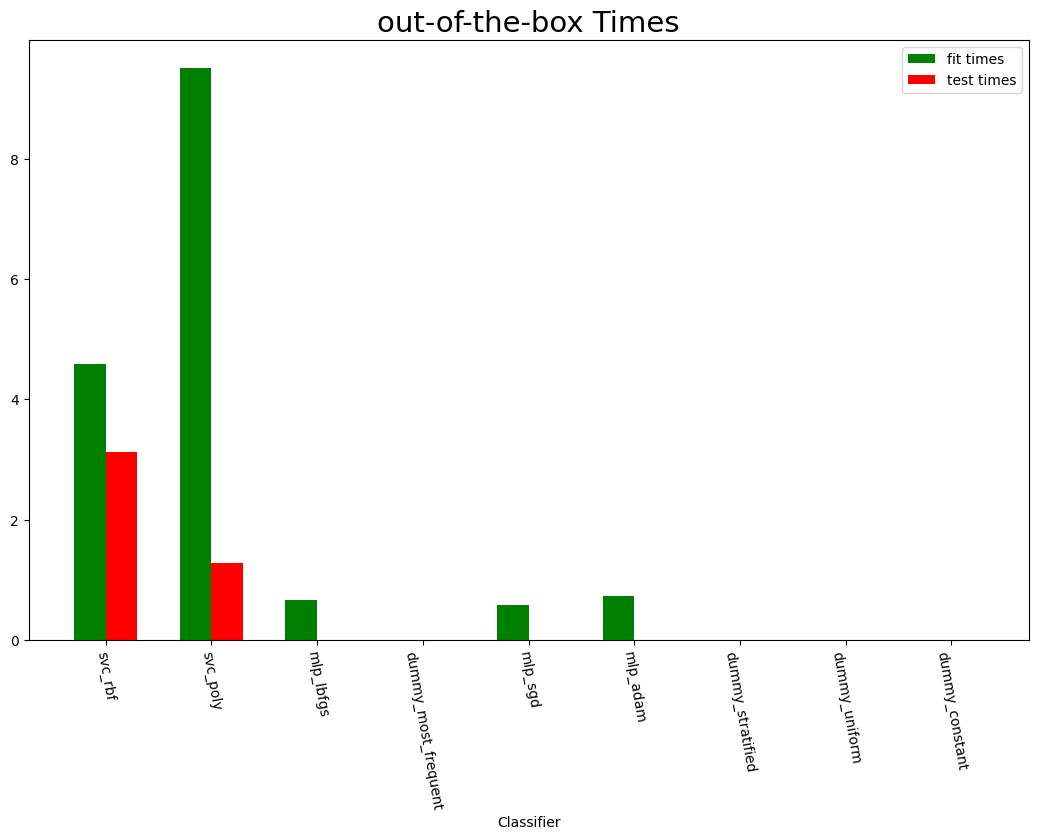

In [14]:
import matplotlib.pyplot as plt

keys, fit_times, test_times, accuracy, f1_macro = zip(*merged_metrics)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, accuracy, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, f1_macro, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['accuracy', 'f1-macro'])
ax.set_title('out-of-the-box Metrics',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)

plt.ylim(0, 1)

plt.show()



fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, fit_times, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, test_times, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['fit times', 'test times'])
ax.set_title('out-of-the-box Times',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)


plt.show()

### Σχολιασμός

Σε αντίθεση με το UCI dataset, το οποίο ήταν εξαιρετικά μικρότερο, εδώ βλέπουμε κακές επιδόσεις out-of-the-box. Είναι προφανές, πως η βελτριστοποίηση είναι απαραίτητη για να επιτευχθεί ένα αξιοπρεπές αποτέλεσμα.  

## Optimisation

Επιλέγουμε να βλετιστοποιήσουμε τον MLP adam και SVC rbf

Έχει γίνει ήδη ένα μικρό μέρος προεπεξεργασίας των δεδομένων, το ελάχιστο για να μπορέσουμε να μετρήσουμε μία out-of-the-box μέτρηση αποδοτικότητας.

Θα χρησιμοποιήσουμε έτοιμες συναρτήσεις από τα sklearn και Optuna

### Scaling

Τα χαρακτηριστικά με πολύ μεγάλες διαφορές στις τιμές τους μπορούν να δημιουργήσουν προβλήματα στην εκπαίδευση. Για το λόγο αυτό θα εφαρμόσουμε τη κανονικοποίηση για να μετασχηματίσουμε τις τιμές των χαρακτηριστικών και να αμβλυθούν οι διαφορές αυτές.

In [15]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

### Over/Under Sampling

Έπειτα από δοκιμές (βλ. τελευταίο κελί), καταλήξαμε στην χρήση συνδυασμού oversampling και undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MultiLabelBinarizer


ros = RandomOverSampler()
train_resampled, train_labels_resampled = ros.fit_resample(train_scaled, train_labels)

train_resampled.shape


(22517, 67)

In [17]:
unique, counts = np.unique(train_labels_resampled, return_counts=True)

for u, c in zip(unique, counts):
    print(str(u)+':'+str(c))

arc:2047
bct:2047
inv:2047
mam:2047
phg:2047
plm:2047
pln:2047
pri:2047
rod:2047
vrl:2047
vrt:2047


### Μείωση Διαστατικότητας (PCA)

In [18]:
from sklearn.decomposition import PCA 

pca = PCA()

train_PCA = pca.fit_transform(train_resampled)
test_PCA = pca.transform(test_scaled)

print(train_PCA.shape)

(22517, 67)


[0.28196574 0.48258362 0.53395235 0.57350864 0.60837514 0.64246015
 0.66929612 0.69461455 0.71313564 0.7296536  0.74443607 0.75890421
 0.77156541 0.78318331 0.79427167 0.80459432 0.81420582 0.82343663
 0.83242136 0.84052556 0.84826465 0.8556325  0.86271028 0.86945362
 0.87571782 0.88177597 0.8876067  0.89330969 0.89878645 0.90404907
 0.90886502 0.91357942 0.91808338 0.92249384 0.92672891 0.930719
 0.93456047 0.93831836 0.94179469 0.94507521 0.94832037 0.95146795
 0.95458773 0.95756713 0.96049296 0.96315796 0.96575411 0.96830803
 0.9708061  0.97320809 0.97546169 0.97766673 0.97985028 0.98194523
 0.98392463 0.98587695 0.98767056 0.98935623 0.99095704 0.99248516
 0.99398407 0.99537805 0.996735   0.99801771 0.99905973 1.
 1.        ]


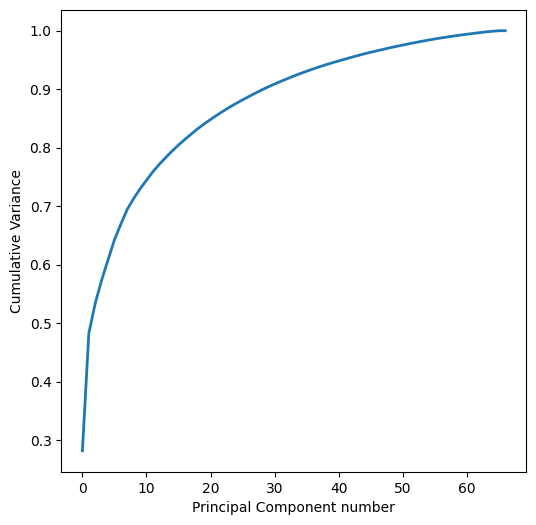

In [19]:
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(6, 6))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

In [20]:
pca = PCA(n_components=45)

train_PCA = pca.fit_transform(train_resampled)
test_PCA = pca.transform(test_scaled)

print(train_PCA.shape)

(22517, 45)


### Αποτελέσματα Εξισορρόπησης και Κανονικοποίησης

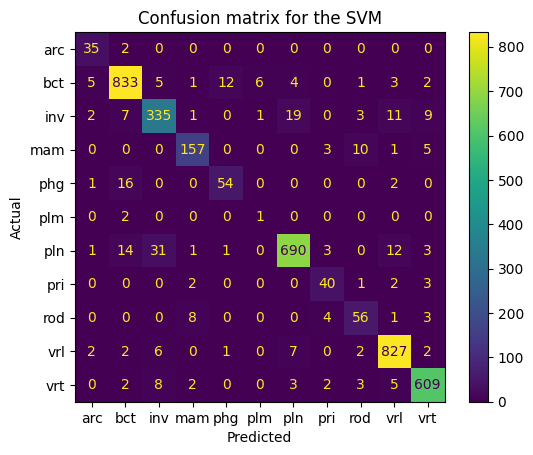

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

name = 'mlp_opt_adam'
mlp = MLPClassifier()
start = time.time()
mlp.fit(train_resampled, train_labels_resampled)
fit_time  = time.time() - start
start = time.time()
preds = mlp.predict(test_scaled)
pred_time  = time.time() - start

kaggle_pred[name] = pred_time
kaggle_fit[name] = fit_time
kaggle_accuracy[name] = accuracy_score(test_labels, preds)
kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

plot_confusion_matrix(mlp, test_scaled, test_labels)  
plt.title('Confusion matrix for the SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 


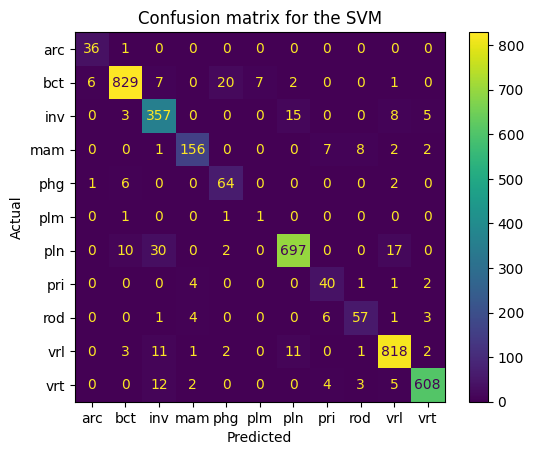

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

name = 'svm_opt_rbf'
svm = SVC()
start = time.time()
svm.fit(train_resampled, train_labels_resampled)
fit_time  = time.time() - start
start = time.time()
preds = svm.predict(test_scaled)
pred_time  = time.time() - start

kaggle_pred[name] = pred_time
kaggle_fit[name] = fit_time
kaggle_accuracy[name] = accuracy_score(test_labels, preds)
kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

plot_confusion_matrix(svm, test_scaled, test_labels)  
plt.title('Confusion matrix for the SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 


### Pipeline / CV / Study
Σε αυτό το σημείο θα χρησιμοποιήσουμε την βιβλιοθήκη Optuna, για να εξετάσουμε τους καλύτερους συνδυασμούς μεταβλητών για την απόδοση των μοντέλων μας

In [26]:
import optuna
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from optuna.visualization import plot_optimization_history

def objective_func(trial):

    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))

    mlp = MLPClassifier(hidden_layer_sizes=tuple(layers))
    pipe = Pipeline(steps=[('scaler', scaler), ('ros', ros), ('pca', pca), ('mlp', mlp)])
    vthreshold = [0, 0.1] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
    n_components = [45, 50, 55]
    estimator = GridSearchCV(pipe, dict( pca__n_components=n_components), cv=2, scoring='f1_macro', n_jobs=-1, verbose=3)
    estimator.fit(train, train_labels)
    pred = estimator.predict(test)
    print(estimator.best_params_)
    return accuracy_score(test_labels, pred)

study = optuna.create_study(direction='maximize') 
study.optimize(objective_func, n_trials=10) 
barplot = [0,0]
barplot[1]=(study.best_trial.value) 

[I 2022-11-26 15:02:13,654] A new study created in memory with name: no-name-b56e0f53-47da-4523-9956-f827bd94d799
[W 2022-11-26 15:02:13,658] Trial 0 failed because of the following error: NameError("name 'hidden_layer_sizes' is not defined")
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/rz/x38ry1m901jcjct47ydtrgph0000gn/T/ipykernel_49050/221998269.py", line 13, in objective_func
    mlp = MLPClassifier(hidden_layer_sizes==tuple(layers))
NameError: name 'hidden_layer_sizes' is not defined


NameError: name 'hidden_layer_sizes' is not defined

### Τελικά Αποτελέσματα

In [24]:
from IPython.display import Markdown

merged_metrics = [(k, kaggle_fit[k], kaggle_pred[k], kaggle_accuracy[k], kaggle_f1[k]) for k in sorted(kaggle_accuracy, key=kaggle_accuracy.get, reverse=True)]

df = pd.DataFrame(merged_metrics, columns=['Classifier', 'Fit Time(s)', 'Test Time(s)','Accuracy','F1-macro'])
Markdown(df.to_markdown())

|    | Classifier          |   Fit Time(s) |   Test Time(s) |   Accuracy |   F1-macro |
|---:|:--------------------|--------------:|---------------:|-----------:|-----------:|
|  0 | svm_opt_rbf         |    2.93059    |    2.54418     |  0.937308  | 0.823791   |
|  1 | mlp_opt_adam        |   27.8851     |    0.0109413   |  0.930655  | 0.811512   |
|  2 | svc_rbf             |    4.5865     |    3.12811     |  0.311668  | 0.100513   |
|  3 | svc_poly            |    9.50887    |    1.27472     |  0.250256  | 0.0568606  |
|  4 | mlp_lbfgs           |    0.659701   |    0.00353217  |  0.22825   | 0.0614462  |
|  5 | dummy_most_frequent |    0.00186205 |    0.000354767 |  0.223132  | 0.0331685  |
|  6 | mlp_sgd             |    0.586501   |    0.00268817  |  0.223132  | 0.0331685  |
|  7 | mlp_adam            |    0.721599   |    0.00481987  |  0.195241  | 0.0577745  |
|  8 | dummy_stratified    |    0.00181103 |    0.000962019 |  0.177584  | 0.0929277  |
|  9 | dummy_uniform       |    0.00233912 |    0.000931978 |  0.0962129 | 0.0723134  |
| 10 | dummy_constant      |    0.00178885 |    2.90871e-05 |  0.0450358 | 0.00783546 |

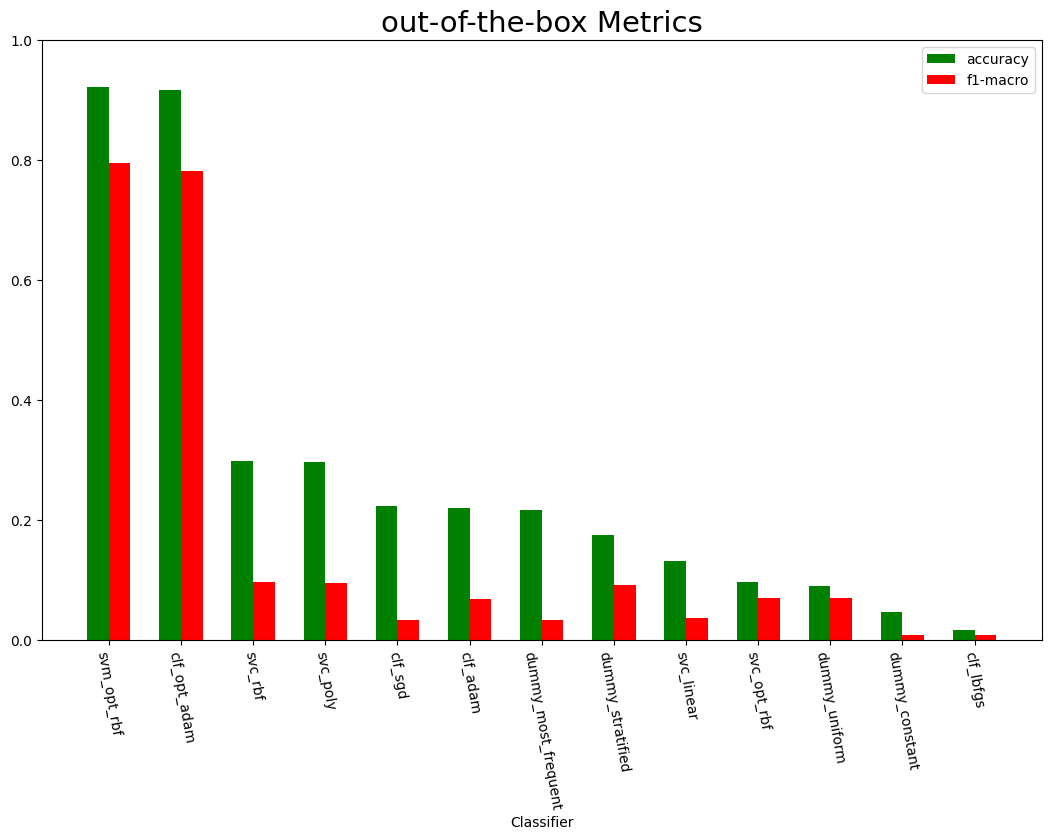

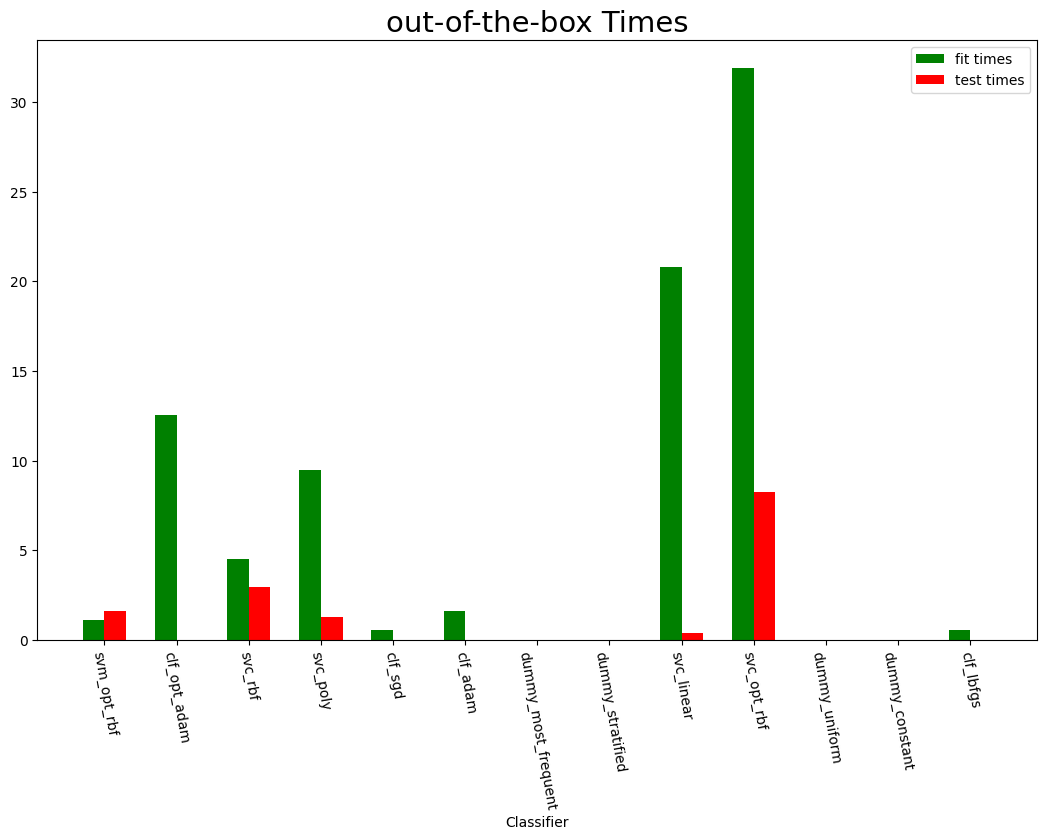

In [ ]:
import matplotlib.pyplot as plt

keys, fit_times, test_times, accuracy, f1_macro = zip(*merged_metrics)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, accuracy, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, f1_macro, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['accuracy', 'f1-macro'])
ax.set_title('out-of-the-box Metrics',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)

plt.ylim(0, 1)

plt.show()



fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, fit_times, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, test_times, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['fit times', 'test times'])
ax.set_title('out-of-the-box Times',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)


plt.show()

## Παρατηρήσεις κατά τον πειραματισμό

Κατά τις δοκιμές διαφόρων τρόπων βελτιστοποίησης, διαπιστώθηκαν τα εξής:


### Scaling - Variance Threshold
- Η χρήση Scaler παρουσίασε εξαιρετική βελτίωση
- Με την εφαρμογή Variance Threshold, μειώθηκε αμελητέα ο χρόνος του fit και train των svc (εκτός του Linear). H αποδοτικότα έμεινε ίδια (στο Linear μειώθηκε). Η διαστατικότητα θα μειωθεί αλλιώς

### Over/Under Sampling
- Με χρήση undersampling, το dataset πέφτει στις 140 σειρές. Ο χρόνος γίνεται ελάχιστος, όμως η αποδοση πέφτει. Λογικό, αφού έχουμε πλεόν 18 δείγματα για κάθε κλάση.
- Βέλτιστη επιλογή φαίνεται να είναι το oversampling.

### PCA
Από το διάγραμμα παρατηρήσαμε πως μια καλή τιμή για την αναλογία χαρακτηριστικών-περιγραφηκότητας είναι τα 45